# Poisson HMM on example session

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import PoissonHMM


# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
from fitting_functions import cross_validate_poismodel

one = ONE(mode='remote')

## Parameters

In [2]:
# Parameters
bin_size = 0.017
multiplier=1
num_states = 2
num_train_batches = 5
threshold = 0.05
sticky = False

# LOAD DATA
cv_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 3]
idx_end_list = [1, 2, 3, 10]

var_interest = 'Lick count'


# Sessions with cross-validated results

In [3]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
    if os.path.exists(result_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


In [ ]:
""" 
NYU-483d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b
ibl_witten_26a9138924-4395-4981-83d1-530f6ff7c8fc   sparse, fit looks bad
SWC_060dac3a4c1-b666-4de0-87e8-8c514483cacf  maybe real, licks missing in the begining of session
ibl_witten_27952870e5-f2a7-4518-9e6d-71585460f6fe good
NR_0017e6043c7d-8f6e-4b66-8309-2ec0abac0f79 misses sparse licks
NYU-4893ad879a-aa42-4150-83e1-38773c9785e4 bad fit
"""

# Fit best params on individual sessions

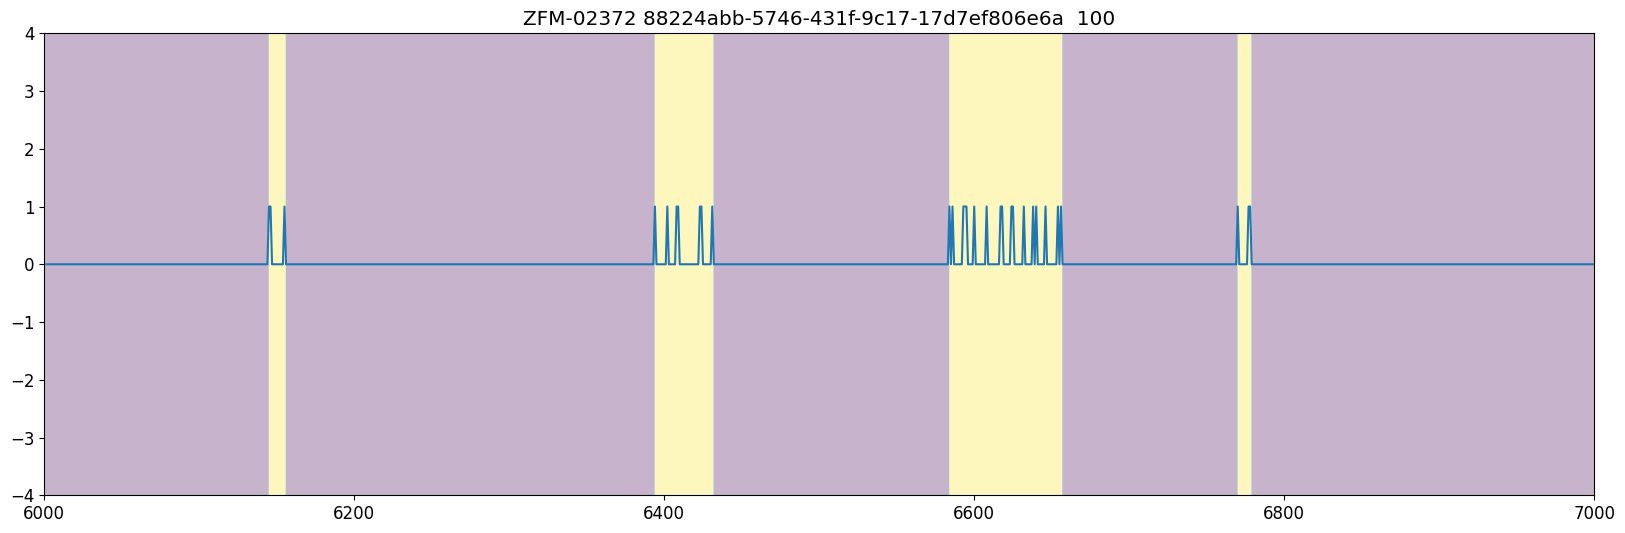

ZFM-0237288224abb-5746-431f-9c17-17d7ef806e6a


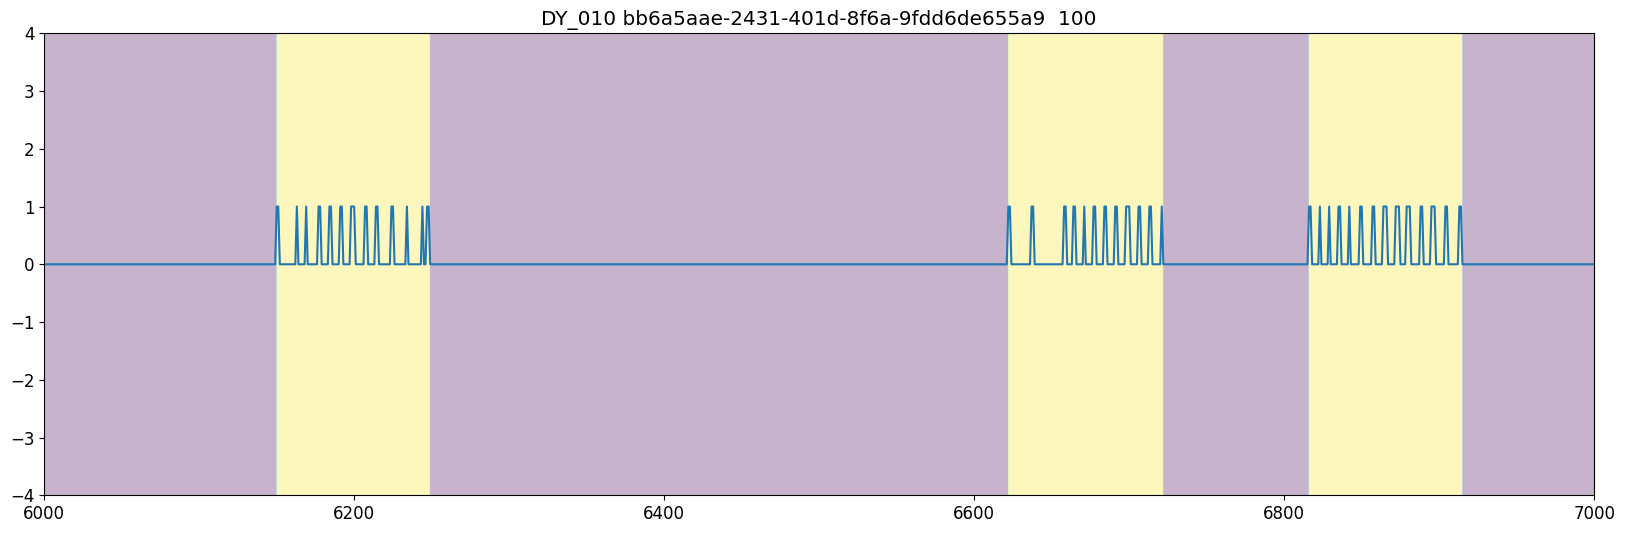

DY_010bb6a5aae-2431-401d-8f6a-9fdd6de655a9


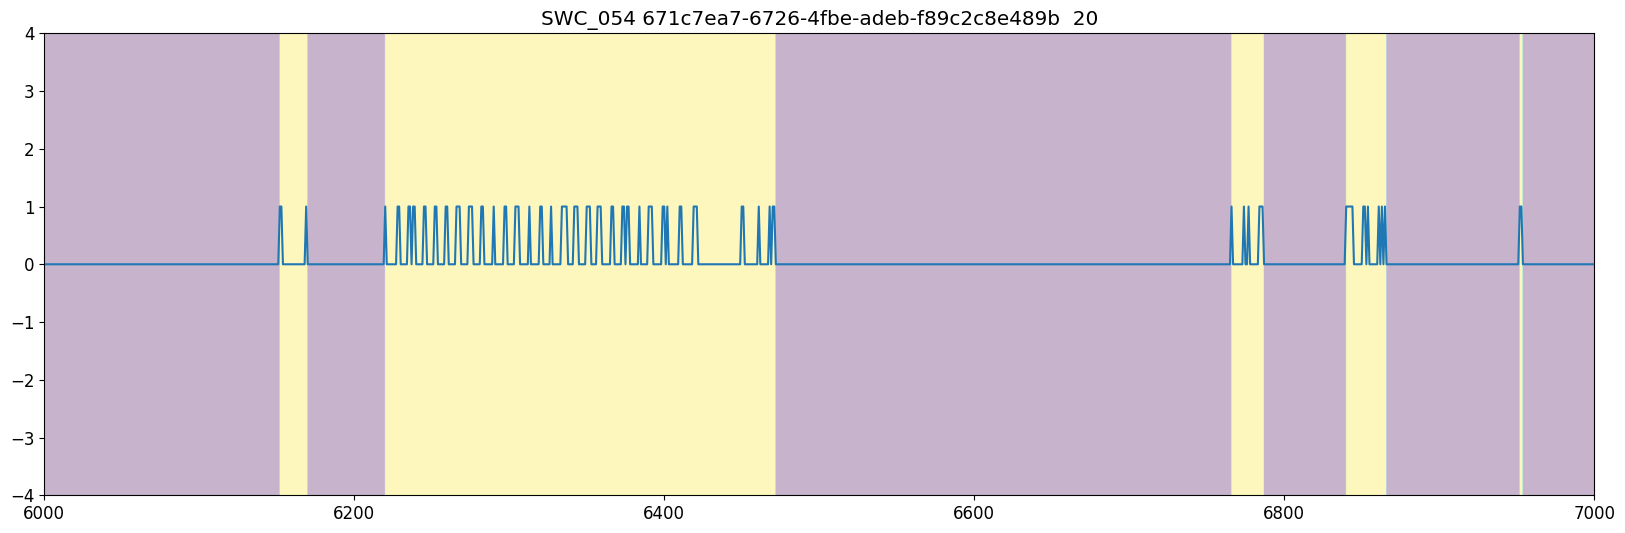

SWC_054671c7ea7-6726-4fbe-adeb-f89c2c8e489b


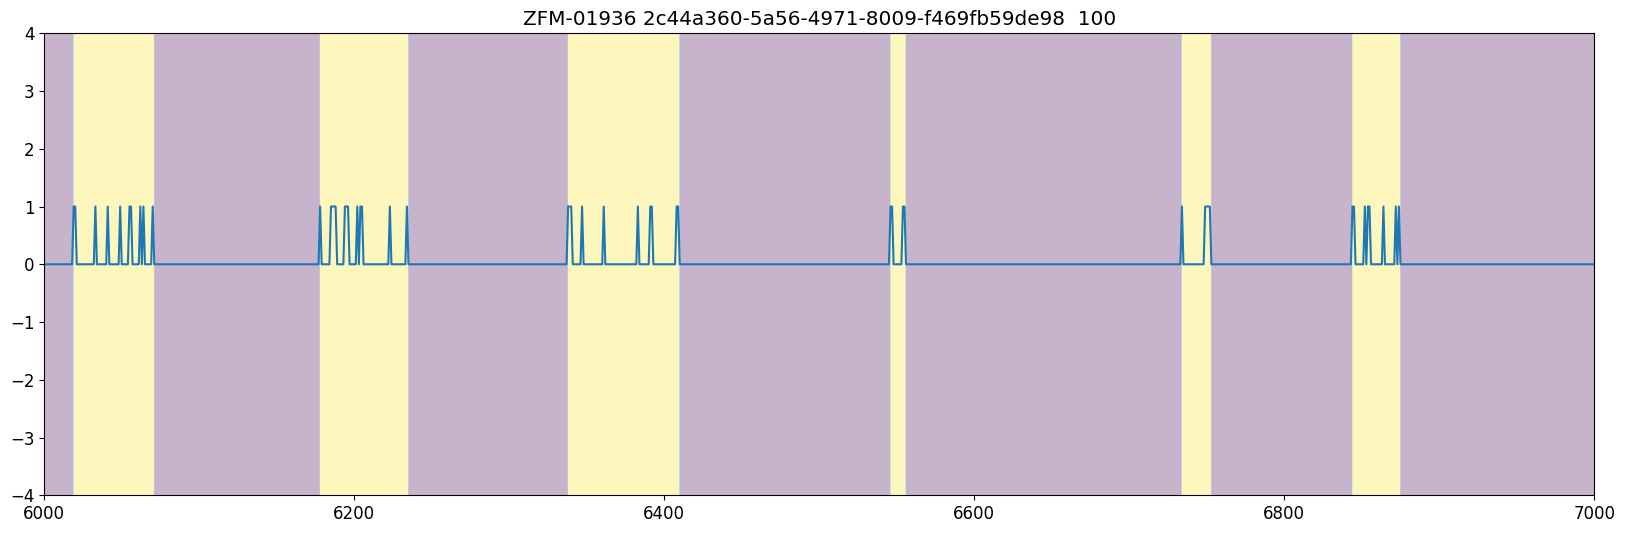

ZFM-019362c44a360-5a56-4971-8009-f469fb59de98


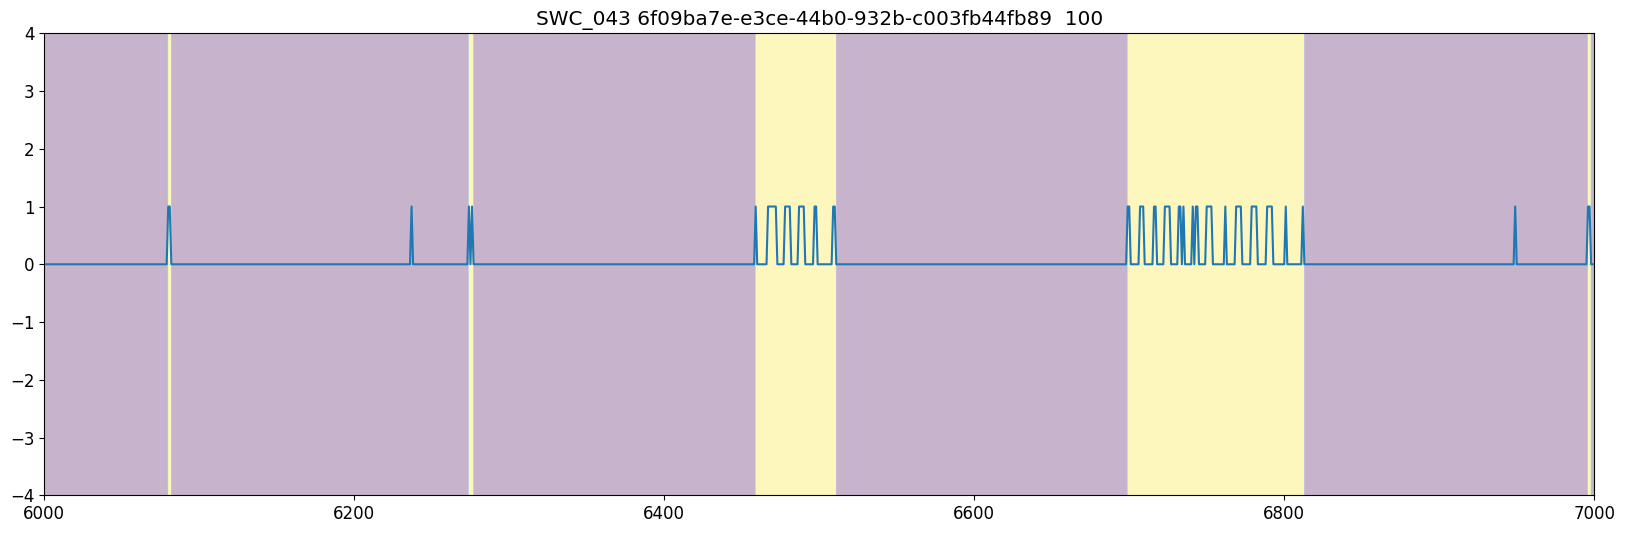

SWC_0436f09ba7e-e3ce-44b0-932b-c003fb44fb89


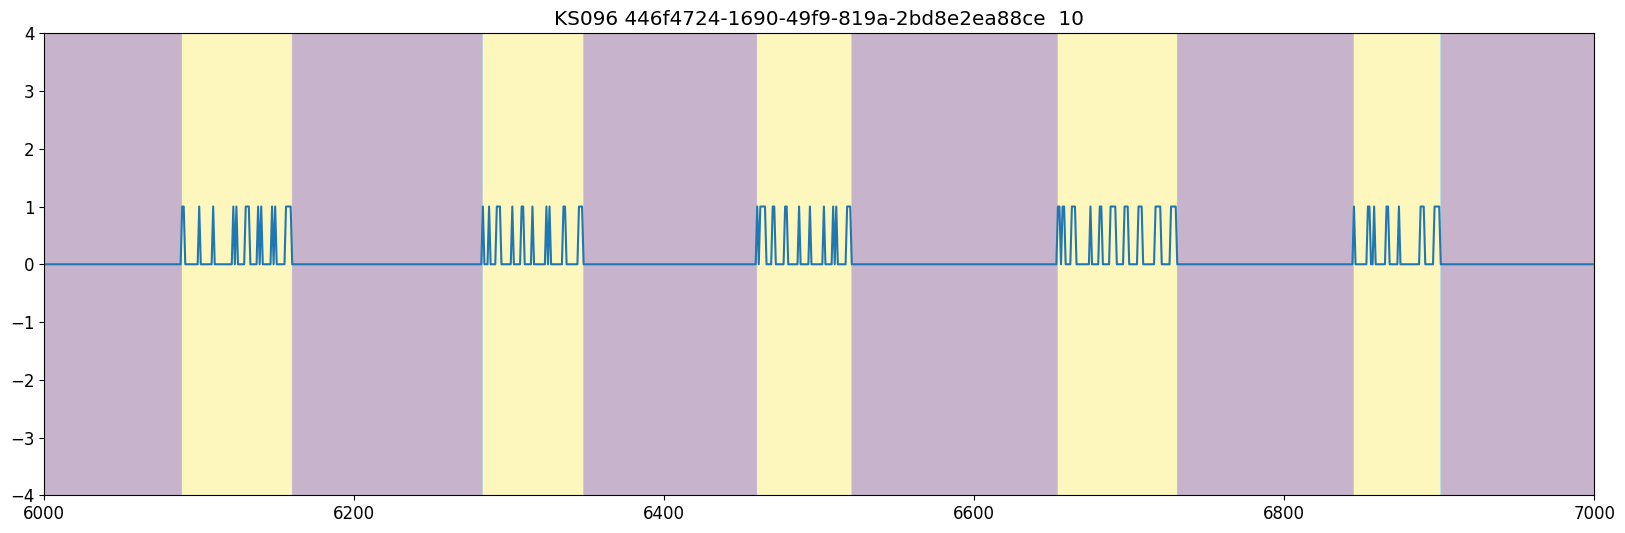

KS096446f4724-1690-49f9-819a-2bd8e2ea88ce


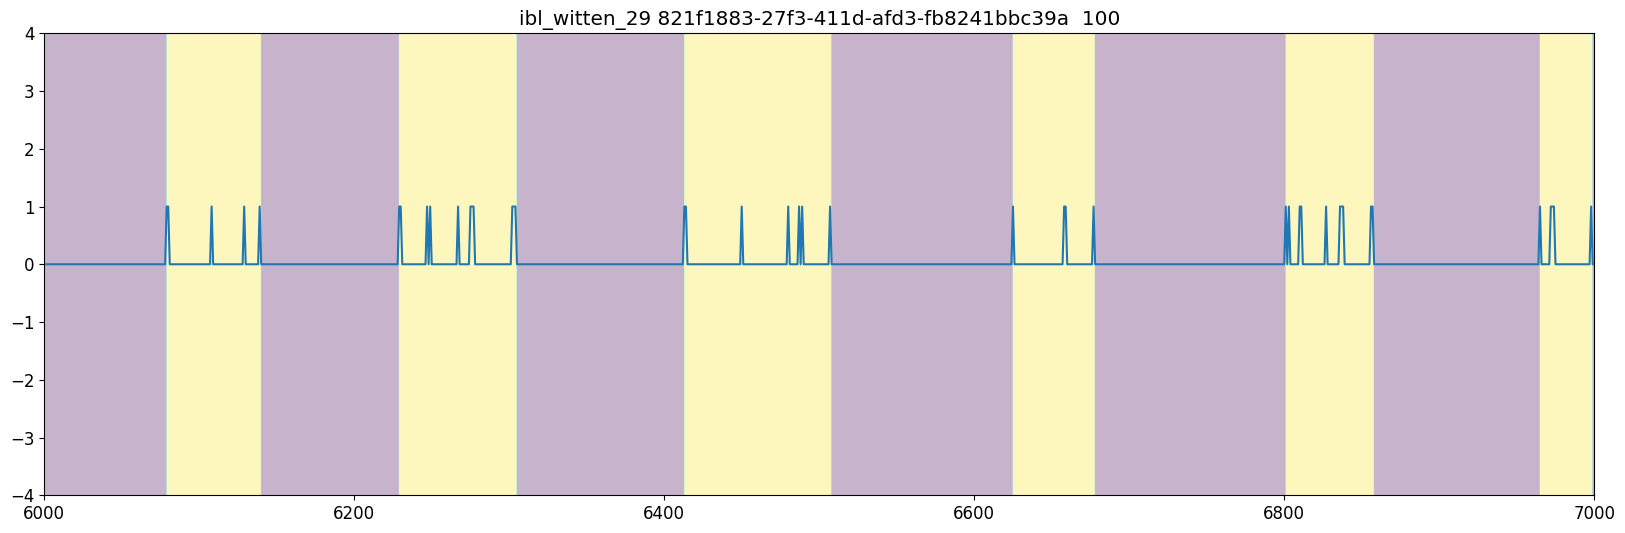

ibl_witten_29821f1883-27f3-411d-afd3-fb8241bbc39a


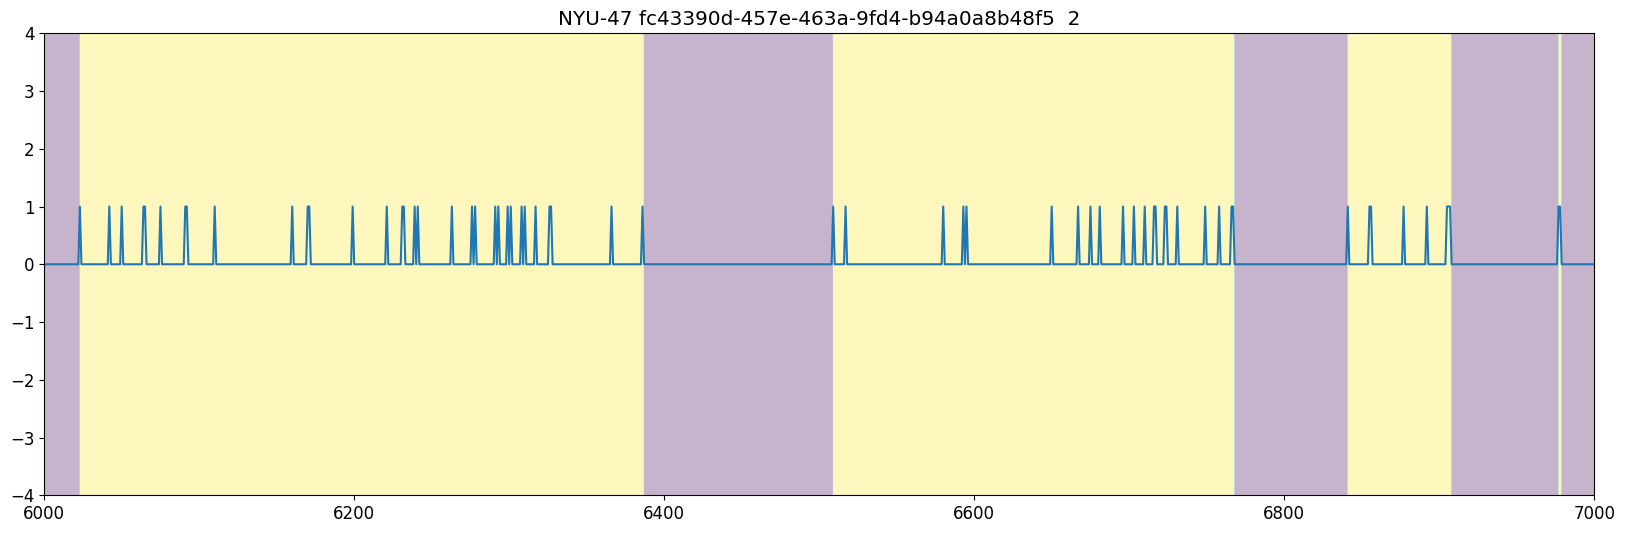

NYU-47fc43390d-457e-463a-9fd4-b94a0a8b48f5


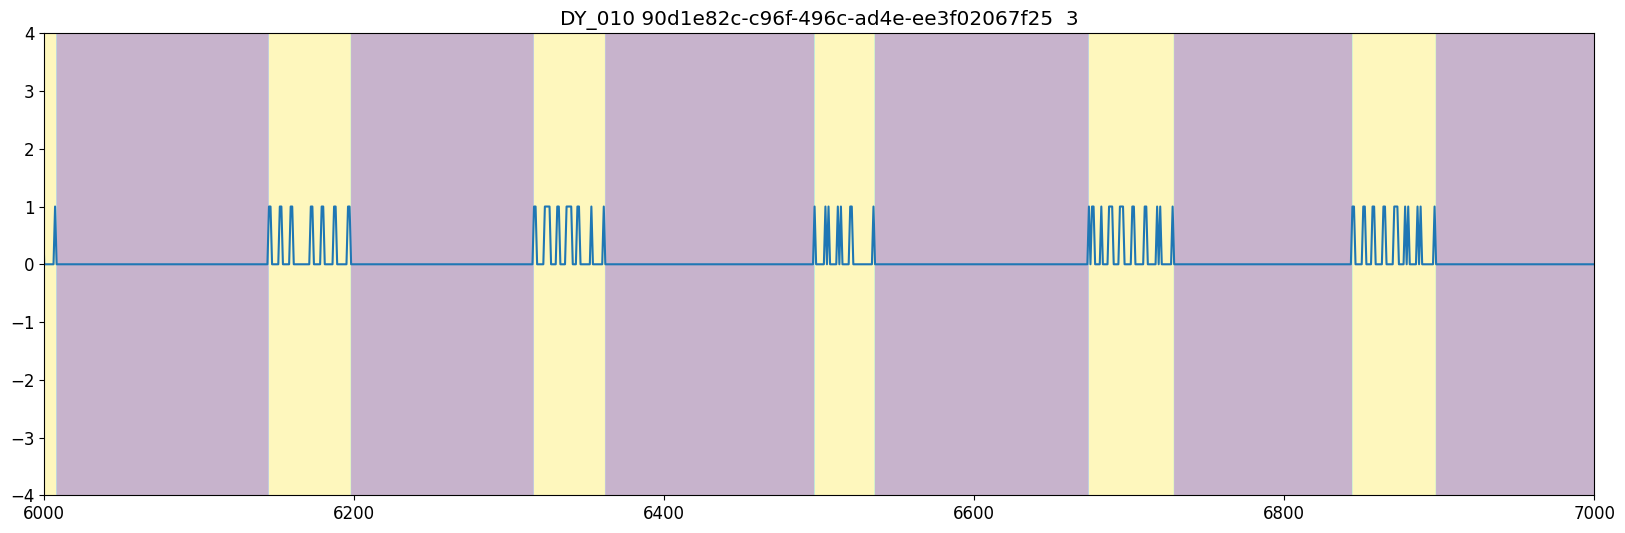

DY_01090d1e82c-c96f-496c-ad4e-ee3f02067f25


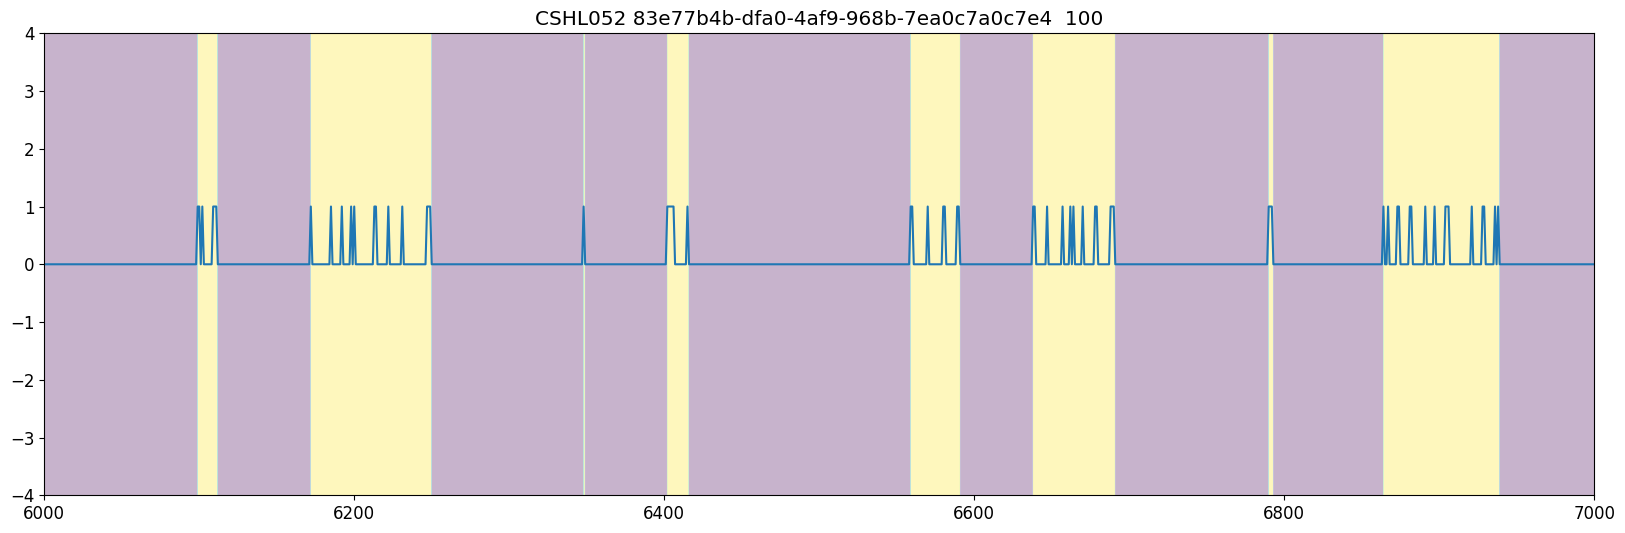

CSHL05283e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4


In [6]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

fit = False
kappa=100
num_train_batches = 5
num_states=2
smooth = False
window=6
downsample=False
downsample_factor=10

for m, mat in enumerate(sessions_to_process[:10]): 
    
    mouse_name = mat[0]
    session = mat[1]
    # mouse_name = 'NYU-48'
    # session = '93ad879a-aa42-4150-83e1-38773c9785e4'
    
    # mouse_name = 'ZFM-02372'
    # session = '88224abb-5746-431f-9c17-17d7ef806e6a'
    fit_id = str(mouse_name+session)
    
    # Get session data
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
    # Get design_matrix
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
    # Get standardized design_matrix
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]
    
    num_timesteps = np.shape(design_matrix)[0]

    if fit:
        # Prepare data format
        emission_dim = np.shape(design_matrix)[1]
        data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
        # data = np.array(unnorm_design_matrix[var_names])[:(num_timesteps // num_train_batches) * num_train_batches].reshape(-1, 1)
        if smooth:
            df = pd.DataFrame(data, columns=["Signal"])
            smoothed_signal = df["Signal"].rolling(window=window, center=True).mean().to_numpy()
            shortened_array = np.array(data)
            shortened_array[int(np.ceil(window/2)):-int(np.floor(window/2))] = smoothed_signal[int(np.ceil(window/2)):-int(np.floor(window/2))].reshape(-1, 1)
        else:
            shortened_array = np.array(data)        
        
        if downsample:
            # Downsample
            downsampled = shortened_array[::downsample_factor].copy()
            shortened_array = downsampled[:(np.shape(downsampled)[0] // num_train_batches) * num_train_batches]

        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        " Fit model with best params"
        # Initialize new hmm and fit
        pois_hmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)

        # init_params, props = arhmm.initialize(key=jr.PRNGKey(0), method=method, emissions=shortened_array)  # not sure if I need to include  
        all_val_lls, fit_params, init_params, baseline_lls = cross_validate_poismodel(
                            pois_hmm, jr.PRNGKey(0), train_emissions, num_train_batches, method='em'
                        )
        # Find parameters for best fold
        # use_fold = np.argmax(all_val_lls)
        use_fold = np.where(all_val_lls == np.nanmax(all_val_lls))[0][0]
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_rates = fit_params[2].rates[use_fold]
     
        # Initialize new hmm
        new_poishmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)
        best_fold_params, props = new_poishmm.initialize(key=jr.PRNGKey(0), 
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,
                                        emission_rates=emission_rates) #method=method,

        # Get state estimates for validation data
        most_likely_states = new_poishmm.most_likely_states(best_fold_params, shortened_array)
        # most_likely_states = arhmm.most_likely_states(init_params, shortened_array, my_inputs)

    else:
        # Get most likely states
        result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
        most_likely_states, use_fold, best_params = pickle.load(open(result_filename, "rb"))
        state_numer, _, kappa_number = best_params
    
    " Plots "
    # Prepare data
    design_matrix_heading = pd.DataFrame(columns=var_names)
    design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
    bins = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    design_matrix_heading['Bin'] = bins
    
    if smooth:
        data = design_matrix_heading[var_names].rolling(window=window, center=True).median()
    else:
        data = design_matrix_heading[var_names]
        
    # Plot raw trace over states
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
    plt.rc('font', size=12)
    ax.plot(data)
    ax.imshow(np.concatenate([most_likely_states])[None,:], 
                extent=(0, len(np.concatenate([most_likely_states])), -4, 4),
                aspect="auto",
                cmap='viridis',
                alpha=0.3) 
    if fit:
        ax.set_title(mouse_name+' '+session+' '+' '+str(kappa))
    else:
        ax.set_title(mouse_name+' '+session+' '+' '+str(kappa_number))
    init = 6000
    ax.set_xlim([init, init+1000])
    plt.show()
    print(fit_id)
    

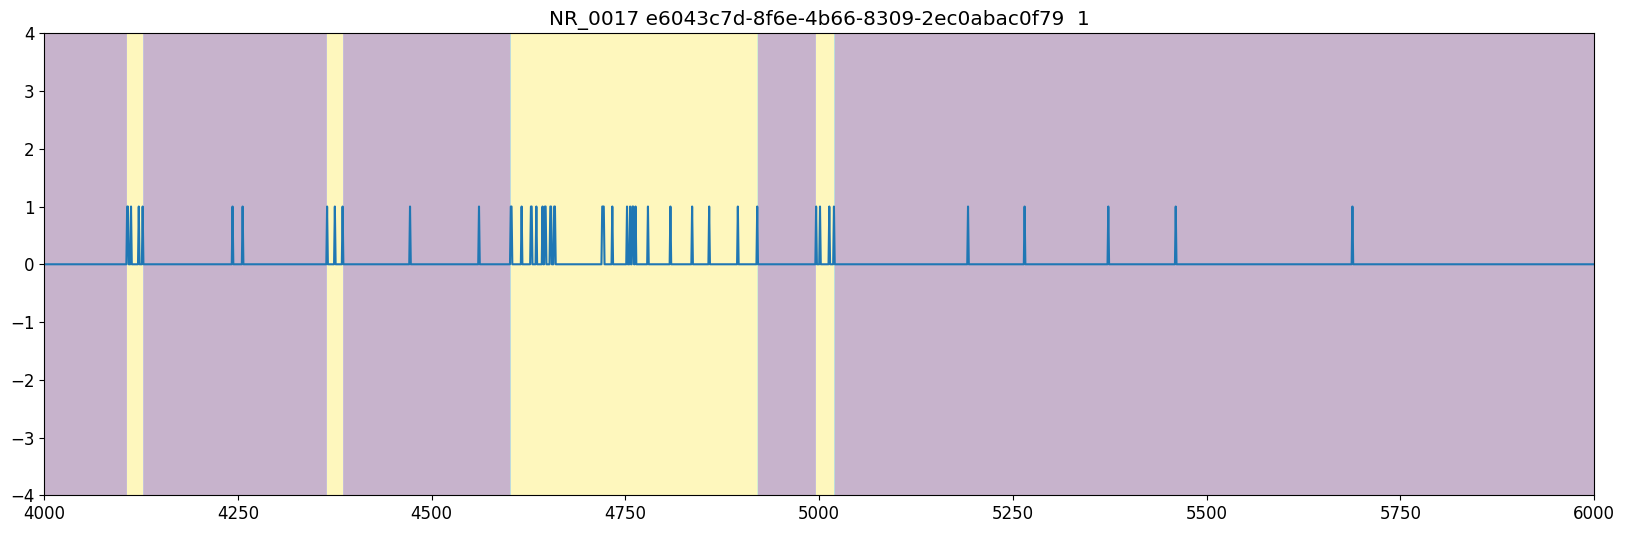

NR_0017e6043c7d-8f6e-4b66-8309-2ec0abac0f79


In [49]:
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
    plt.rc('font', size=12)
    ax.plot(data)
    ax.imshow(np.concatenate([most_likely_states])[None,:], 
                extent=(0, len(np.concatenate([most_likely_states])), -4, 4),
                aspect="auto",
                cmap='viridis',
                alpha=0.3) 
    if fit:
        ax.set_title(mouse_name+' '+session+' '+' '+str(kappa))
    else:
        ax.set_title(mouse_name+' '+session+' '+' '+str(kappa_number))
    init = 4000
    ax.set_xlim([init, init+2000])
    plt.show()
    print(fit_id)